In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.metrics import mean_squared_error

In [2]:
df=pd.read_csv('../input/hourly-energy-consumption/PJME_hourly.csv')
df=df.set_index('Datetime')

df.index=pd.to_datetime(df.index)
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


<AxesSubplot:xlabel='Datetime'>

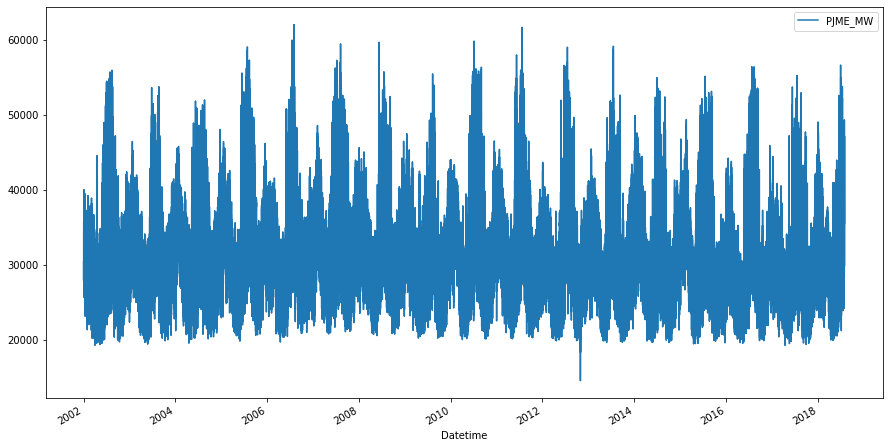

In [3]:
df.plot(figsize=(15,8))

# **TRAIN/TEST SPLIT** 

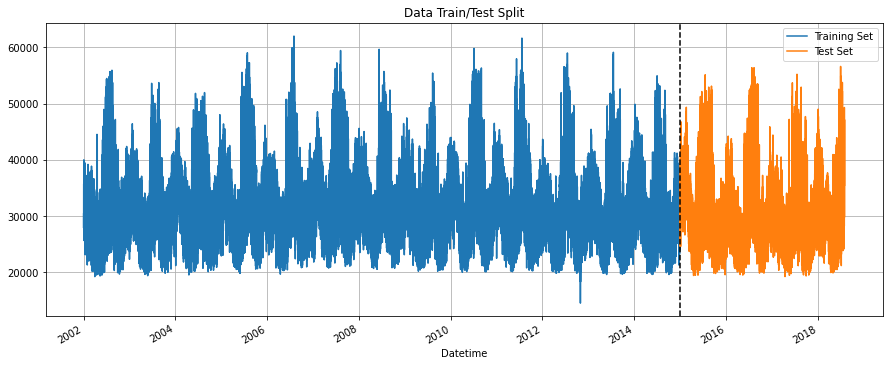

In [4]:
train=df.loc[df.index<'01-01-2015']
test=df.loc[df.index>='01-01-2015']

fig,ax =plt.subplots(figsize=(15,6))
train.plot(ax=ax,label='TRAINING SET')
test.plot(ax=ax,label='TEST SET')
ax.axvline('01-01-2015',color='black',ls='--')
plt.legend(['Training Set','Test Set'])
plt.title('Data Train/Test Split')
plt.grid(visible=True)
plt.show()

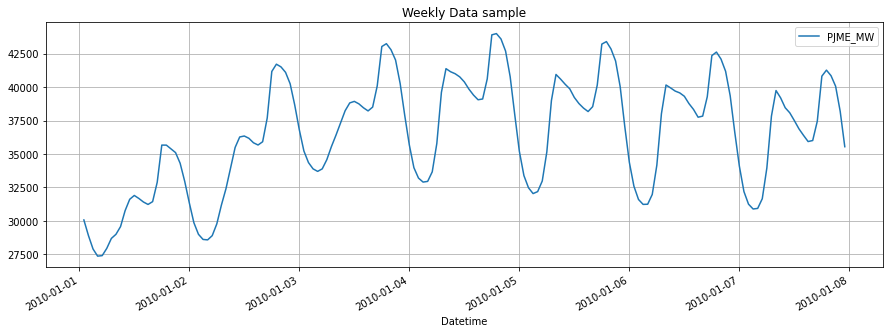

In [5]:
df.loc[(df.index>'01-01-2010')&(df.index<'01-08-2010')].plot(figsize=(15,5),title='Weekly Data sample')
plt.grid(visible=True)


 # **FEATURE CREATION**

In [6]:
def create_features(df):
    """
    create features based on time series index
    """
    df=df.copy()
    df['hour']=df.index.hour
    df['day of week']=df.index.day_of_week
    df['quarter']=df.index.quarter
    df['month']=df.index.month
    df['year']=df.index.year
    df['day of year']=df.index.day_of_year
    return df
df=create_features(df)

# VISUALIZE OUR FEATURE /TARGET RELATIONSHIP

<AxesSubplot:xlabel='hour', ylabel='PJME_MW'>

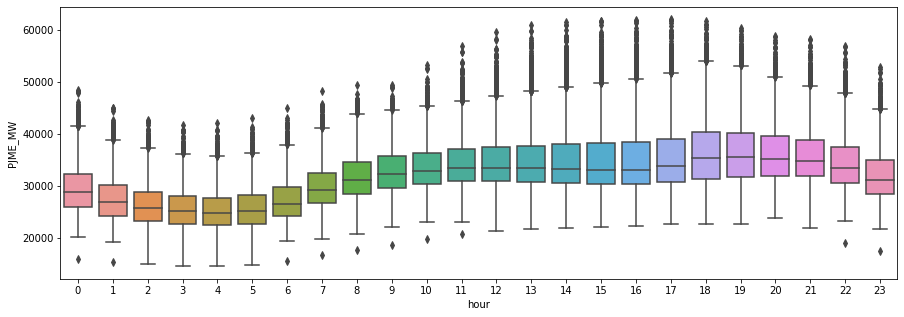

In [7]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df,x='hour',y='PJME_MW')

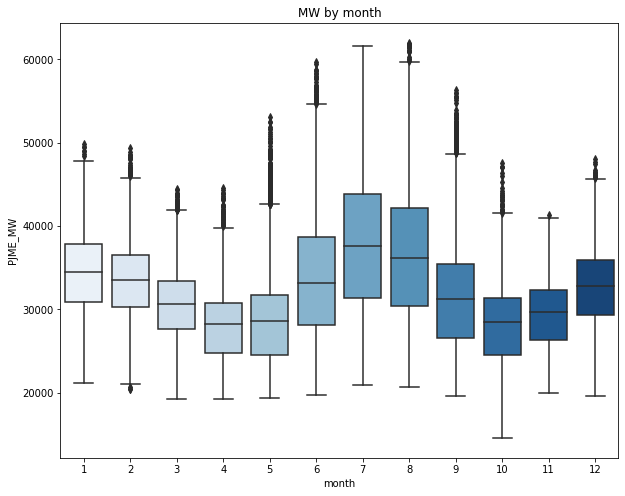

In [8]:
fig, ax=plt.subplots(figsize=(10,8))
sns.boxplot(data=df,x='month',y='PJME_MW',palette='Blues')
ax.set_title("MW by month")
plt.show()


In [9]:
train=create_features(train)
test=create_features(test)

FEATURES=['hour', 'day of week', 'quarter', 'month', 'year','day of year']
TARGET=['PJME_MW']

In [10]:
x_train=train[FEATURES]
y_train=train[TARGET]

x_test=test[FEATURES]
y_test=test[TARGET]

# **CREATE OUR MODEL**

In [17]:
reg=xgb.XGBRegressor(n_estimators=1000,early_stopping_ronds=50,learning_rate=0.01)
reg.fit(x_train,y_train,eval_set=[(x_train,y_train),(x_test,y_test)],verbose=100)

[11:17:51] WARNING: ../src/learner.cc:627: 
Parameters: { "early_stopping_ronds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:32601.87826	validation_1-rmse:31654.28935
[100]	validation_0-rmse:12342.13873	validation_1-rmse:11517.66004
[200]	validation_0-rmse:5373.33346	validation_1-rmse:5165.30811
[300]	validation_0-rmse:3375.20923	validation_1-rmse:3829.25476
[400]	validation_0-rmse:2882.55200	validation_1-rmse:3715.04915
[500]	validation_0-rmse:2699.48868	validation_1-rmse:3756.65302
[600]	validation_0-rmse:2601.12457	validation_1-rmse:3806.77964
[700]	validation_0-rmse:2516.64000	validation_1-rmse:3845.80090
[800]	validation_0-rmse:2459.07473	validation_1-rmse:3873.51681
[900]	validation_0-rmse:2422.21030	validation_1-rms

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_ronds=50, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0, ...)

# **FEATURE IMPORTANCE**

In [12]:
fi=pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])

<Figure size 1500x800 with 0 Axes>

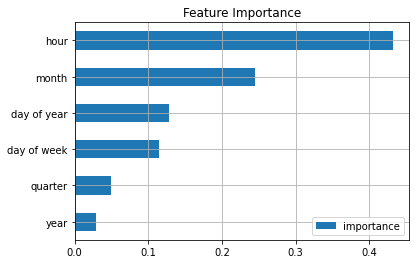

In [13]:
plt.figure(figsize=(15,8),dpi=100)
fi.sort_values('importance').plot(kind='barh',title='Feature Importance')
plt.grid(True)
plt.show()

# FORECAST ON TEST

In [14]:
test['prediction']=reg.predict(x_test)
df=df.merge(test['prediction'],how='left',left_index=True,right_index=True)

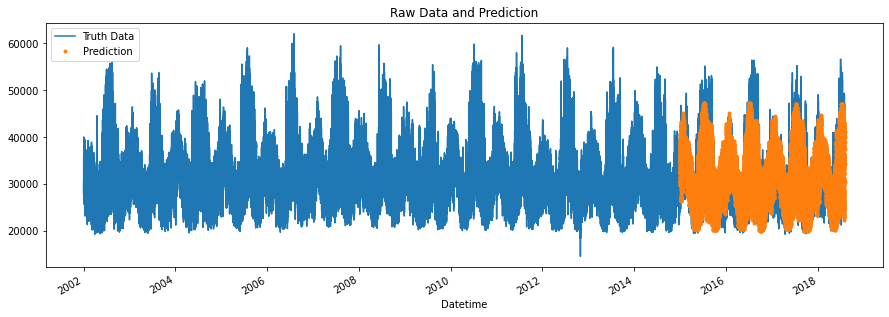

In [18]:
ax=df[['PJME_MW']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax,style='.')
plt.legend(['Truth Data','Prediction'])
ax.set_title('Raw Data and Prediction')
plt.show()

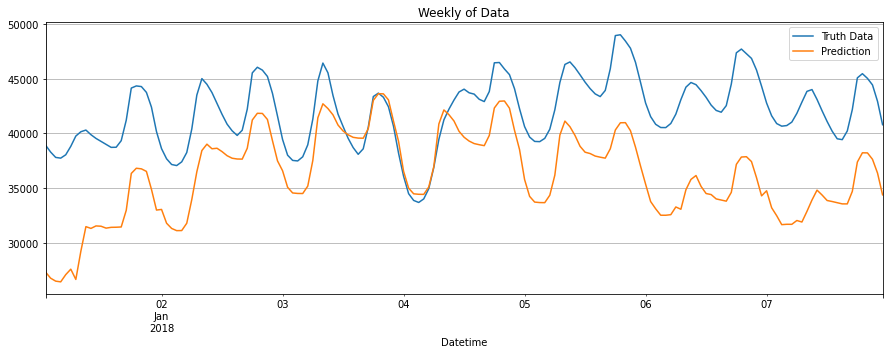

In [22]:
ax=df.loc[(df.index>'01-01-2018')&(df.index<'01-08-2018')]['PJME_MW']\
    .plot(figsize=(15,5),title='Weekly of Data')
df.loc[(df.index>'01-01-2018')&(df.index<'01-08-2018')]['prediction']\
    .plot()
plt.legend(['Truth Data','Prediction'])
plt.grid(visible=True)
plt.show()
